In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif, SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, matthews_corrcoef
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import shap

D:\Adi\Anaconda\envs\adik1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Dataset Load**

In [2]:
df = pd.read_csv('american_companies_bankruptcy.csv')

## **EDA**

In [3]:
df.info

<bound method DataFrame.info of       company_name status_label  year  Current assets  Cost of goods sold  \
0              C_1        alive  1999         511.267             833.107   
1              C_1        alive  2000         485.856             713.811   
2              C_1        alive  2001         436.656             526.477   
3              C_1        alive  2002         396.412             496.747   
4              C_1        alive  2003         432.204             523.302   
...            ...          ...   ...             ...                 ...   
78677       C_8971        alive  2014         233.211              43.338   
78678       C_8971        alive  2015         105.559              59.184   
78679       C_8971        alive  2016          63.971              69.074   
78680       C_8971        alive  2017         135.207              66.527   
78681       C_8971        alive  2018          82.589              68.817   

       Depreciation and amortization   EBIT

In [4]:
df.describe()

,year,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market value,Net sales,Total assets,Total Long-term debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses
count,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,7.868200e+04,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
mean,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,3.414355e+03,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,1.841410e+04,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,1.000000e-04,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,3.498000e+01,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,2.275118e+02,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,1.244890e+03,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250
max,2018.000000,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


In [5]:
df.columns = df.columns.str.strip()
df.columns

Index(['company_name', 'status_label', 'year', 'Current assets',
       'Cost of goods sold', 'Depreciation and amortization', 'EBITDA',
       'Inventory', 'Net Income', 'Total Receivables', 'Market value',
       'Net sales', 'Total assets', 'Total Long-term debt', 'EBIT',
       'Gross Profit', 'Total Current Liabilities', 'Retained Earnings',
       'Total Revenue', 'Total Liabilities', 'Total Operating Expenses'],
      dtype='object')

In [6]:
df_grouped = df.groupby('company_name').agg({
    'Current assets': 'sum',
    'Cost of goods sold': 'sum',
    'Depreciation and amortization': 'mean',
    'EBITDA': 'mean',
    'Inventory': 'mean',
    'Net Income': 'mean',
    'Total Receivables': 'sum',
    'Market value': 'mean',
    'Net sales': 'mean',
    'Total assets': 'sum',
    'Total Long-term debt': 'sum',
    'EBIT': 'mean',
    'Gross Profit': 'mean',
    'Total Current Liabilities': 'sum',
    'Retained Earnings': 'mean',
    'Total Revenue': 'mean',
    'Total Liabilities': 'sum',
    'Total Operating Expenses': 'sum',
    'status_label': 'last'
}).reset_index()


In [7]:
df_grouped

,company_name,Current assets,Cost of goods sold,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market value,Net sales,Total assets,Total Long-term debt,EBIT,Gross Profit,Total Current Liabilities,Retained Earnings,Total Revenue,Total Liabilities,Total Operating Expenses,status_label
0,C_1,14291.541,20390.221,50.438474,127.150053,441.274684,36.263000,3768.236,748.541426,1341.480579,24789.889,5767.287,76.711579,268.311053,5267.030,379.262105,1341.480579,12800.140,23072.280,alive
1,C_10,19628.881,44243.953,426.108500,1117.853000,203.018750,314.561700,8461.462,5253.193310,3330.050650,239440.233,62572.695,691.744500,1117.853000,26811.239,1461.767850,3330.050650,165884.518,44243.953,alive
2,C_100,663.087,380.072,11.712067,29.013467,1.691133,22.602200,143.749,624.822920,63.418400,2676.485,14.500,17.301400,38.080267,213.130,150.406267,63.418400,277.611,516.074,alive
3,C_1000,55637.293,40538.446,154.053800,1673.216550,213.319000,882.498700,21538.625,18809.292005,5460.389600,130914.658,24316.145,1519.162750,3433.467300,50431.551,5520.977450,5460.389600,90824.995,75743.461,alive
4,C_1001,449513.300,2189218.800,362.680000,2246.110000,9939.015000,1049.510000,193620.400,20111.374065,115997.700000,649551.400,73365.100,1883.430000,6536.760000,394850.600,6654.100000,115997.700000,506437.700,2275031.800,alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966,C_995,9037.574,24462.311,158.399857,478.705429,478.041714,113.600714,4137.165,2346.040900,4567.920000,20563.546,4870.700,320.305571,1073.304143,7303.195,924.370000,4567.920000,19210.347,28624.502,alive
8967,C_996,236.307,303.301,3.350333,6.168333,50.680667,-0.297667,79.573,15.173600,124.424333,356.255,130.124,2.818000,23.324000,130.439,24.299000,124.424333,270.151,354.768,alive
8968,C_997,20954.400,37748.952,82.670000,555.892400,500.705000,322.955000,8156.800,6881.860115,3328.890000,75628.400,20815.800,473.222400,1441.442400,20376.100,609.980000,3328.890000,49265.700,55459.952,alive
8969,C_998,30106.143,55433.891,84.282900,263.509550,310.625800,-71.268200,9913.576,2643.577295,3296.034850,65491.179,8305.649,179.226650,524.340300,26933.878,-550.088900,3296.034850,45411.090,60650.506,failed


In [8]:
df1 = df_grouped

In [9]:
df1['Original_Index'] = df1.index 

## **AUTOMATED EDA USING PANDAS PROFILING**

## **FEATURE ENGINEERING**

In [10]:
df1['EBITDA_Margin'] = df1['EBITDA'] / df1['Total Revenue']
df1['Net_Profit_Margin'] = df1['Net Income'] / df1['Total Revenue']
df1['Debt_Ratio'] = df1['Total Liabilities'] / df1['Total assets']
df1['ROI'] = (df1['Net Income'] / (df1['Total assets'] + df1['Total Liabilities'])) * 100
df1['Asset_Turnover'] = df1['Net sales'] / df1['Total assets']
df1['Operating_Profit_Margin'] = df1['EBIT'] / df1['Total Revenue']
df1['PE_Ratio'] = df1['Market value'] / df1['Net Income']
df1['Working_Capital'] = df1['Current assets'] - df1['Total Current Liabilities']


In [11]:
df1.columns

Index(['company_name', 'Current assets', 'Cost of goods sold',
       'Depreciation and amortization', 'EBITDA', 'Inventory', 'Net Income',
       'Total Receivables', 'Market value', 'Net sales', 'Total assets',
       'Total Long-term debt', 'EBIT', 'Gross Profit',
       'Total Current Liabilities', 'Retained Earnings', 'Total Revenue',
       'Total Liabilities', 'Total Operating Expenses', 'status_label',
       'Original_Index', 'EBITDA_Margin', 'Net_Profit_Margin', 'Debt_Ratio',
       'ROI', 'Asset_Turnover', 'Operating_Profit_Margin', 'PE_Ratio',
       'Working_Capital'],
      dtype='object')

## **Outilers Handling**

In [12]:
for col in ['Current assets', 'Cost of goods sold',
       'Depreciation and amortization', 'EBITDA', 'Inventory', 'Net Income',
       'Total Receivables', 'Market value', 'Net sales', 'Total assets',
       'Total Long-term debt', 'EBIT', 'Gross Profit',
       'Total Current Liabilities', 'Retained Earnings', 'Total Revenue',
       'Total Liabilities', 'Total Operating Expenses',
       'EBITDA_Margin', 'Net_Profit_Margin', 'Debt_Ratio', 'ROI',
       'Asset_Turnover', 'Operating_Profit_Margin', 'PE_Ratio',
       'Working_Capital']:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"{col}:")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Outliers: {df1[(df1[col] < lower_bound) | (df1[col] > upper_bound)].shape[0]}")

Current assets:
Lower Bound: -3164.613, Upper Bound: 5470.975
Outliers: 1400
Cost of goods sold:
Lower Bound: -4060.342, Upper Bound: 6941.574
Outliers: 1522
Depreciation and amortization:
Lower Bound: -43.05139285714285, Upper Bound: 74.44203571428571
Outliers: 1326
EBITDA:
Lower Bound: -112.14393055555556, Upper Bound: 179.66945833333332
Outliers: 1473
Inventory:
Lower Bound: -55.98485576923078, Upper Bound: 93.33091346153847
Outliers: 1448
Net Income:
Lower Bound: -53.000617835595776, Upper Bound: 51.85978266716943
Outliers: 2050
Total Receivables:
Lower Bound: -890.2047500000001, Upper Bound: 1517.46125
Outliers: 1449
Market value:
Lower Bound: -1127.64524, Upper Bound: 1969.2952200000002
Outliers: 1257
Net sales:
Lower Bound: -830.9919107142858, Upper Bound: 1437.2331845238095
Outliers: 1333
Total assets:
Lower Bound: -8160.151749999999, Upper Bound: 13994.35025
Outliers: 1455
Total Long-term debt:
Lower Bound: -1636.9220000000003, Upper Bound: 2734.634
Outliers: 1584
EBIT:
Lower 

In [13]:
def handle_outliers_iqr(df1, features):
    for feature in features:
        Q1 = df1[feature].quantile(0.25)
        Q3 = df1[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df1[feature] = np.where(df1[feature] < lower_bound, lower_bound, df1[feature])
        df1[feature] = np.where(df1[feature] > upper_bound, upper_bound, df1[feature])
    
    return df1

features = [
    'Current assets', 'Cost of goods sold',
       'Depreciation and amortization', 'EBITDA', 'Inventory', 'Net Income',
       'Total Receivables', 'Market value', 'Net sales', 'Total assets',
       'Total Long-term debt', 'EBIT', 'Gross Profit',
       'Total Current Liabilities', 'Retained Earnings', 'Total Revenue',
       'Total Liabilities', 'Total Operating Expenses',
       'EBITDA_Margin', 'Net_Profit_Margin', 'Debt_Ratio', 'ROI',
       'Asset_Turnover', 'Operating_Profit_Margin', 'PE_Ratio',
       'Working_Capital'
]

# Process outliers
df1 = handle_outliers_iqr(df1, features)

<Axes: ylabel='ROI'>

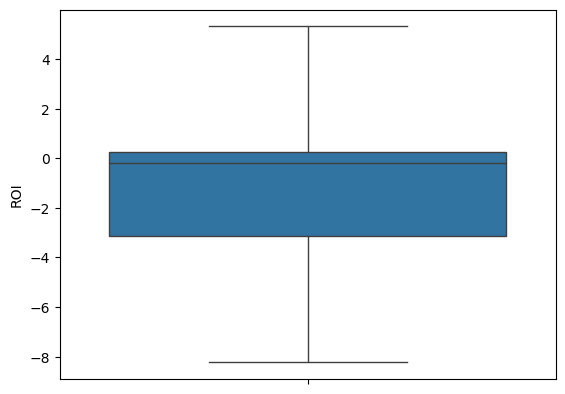

In [14]:
sns.boxplot(df1['ROI'])

## **Label Encoding**

In [15]:
print(df1['status_label'].unique())

['alive' 'failed']


In [16]:
df1['status_label'] = np.where(df1['status_label'] == 'alive', 1, 0)

In [17]:
df1['status_label'].value_counts()

status_label
1    8362
0     609
Name: count, dtype: int64

In [18]:
move_column = df1.pop('status_label')
df1['status_label'] = move_column

In [19]:
x = df1.drop(['status_label', 'company_name', 'Original_Index'], axis = 1)
y = df1['status_label']

## **Removing Multicolinearity**

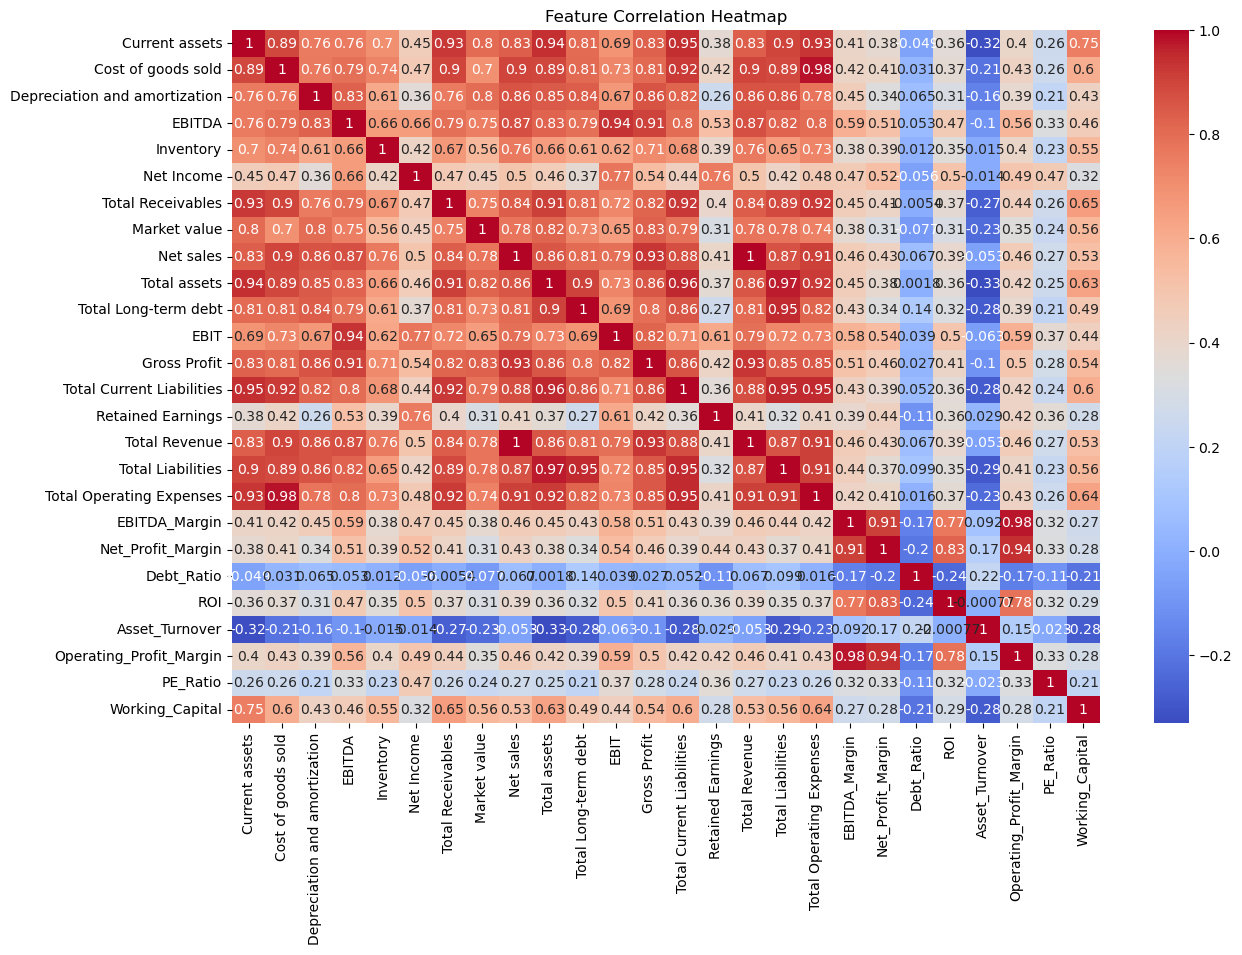

In [20]:
plt.figure(figsize=(14,9))
sns.heatmap(x.corr(), annot=True, cmap = 'coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [21]:
vif_data = pd.DataFrame()
vif_data['Current assets', 'Cost of goods sold', 'Depreciation and amortization',
       'EBITDA', 'Inventory', 'Net Income', 'Total Receivables',
       'Market value', 'Net sales', 'Total assets', 'Total Long-term debt',
       'EBIT', 'Gross Profit', 'Total Current Liabilities',
       'Retained Earnings', 'Total Revenue', 'Total Liabilities',
       'Total Operating Expenses', 'EBITDA_Margin', 'Net_Profit_Margin',
       'Debt_Ratio', 'ROI', 'Asset_Turnover', 'Operating_Profit_Margin',
       'PE_Ratio', 'Working_Capital'] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(vif_data)


D:\Adi\Anaconda\envs\adik1\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


   (Current assets, Cost of goods sold, Depreciation and amortization, EBITDA, Inventory, Net Income, Total Receivables, Market value, Net sales, Total assets, Total Long-term debt, EBIT, Gross Profit, Total Current Liabilities, Retained Earnings, Total Revenue, Total Liabilities, Total Operating Expenses, EBITDA_Margin, Net_Profit_Margin, Debt_Ratio, ROI, Asset_Turnover, Operating_Profit_Margin, PE_Ratio, Working_Capital)  \
0                                      Current assets                                                                                                                                                                                                                                                                                                                                                                                        
1                                  Cost of goods sold                                                                                       

In [22]:
x = x.drop(columns=["Net sales", "Total Revenue", "Total Liabilities", "Gross Profit"])
x["Working_Capital_Ratio"] = x["Working_Capital"] / x["Total Current Liabilities"]
x["Debt_to_Equity_Ratio"] = x["Total Long-term debt"] / x["Retained Earnings"]
x["ROA"] = x["Net Income"] / x["Total assets"]
# Drop the original features after combining
x = x.drop(columns=["Working_Capital", "Total Current Liabilities", "Total Long-term debt", "Retained Earnings"])
x = x.drop(columns=["EBIT", "Operating_Profit_Margin"])
x = x.drop(columns=["Cost of goods sold"])
x = x.drop(columns=["Total Operating Expenses"])
x = x.drop(columns=["Current assets"])

In [23]:
vif_data = pd.DataFrame()
vif_data['Current assets', 'Cost of goods sold', 'Depreciation and amortization',
       'EBITDA', 'Inventory', 'Net Income', 'Total Receivables',
       'Market value', 'Net sales', 'Total assets', 'Total Long-term debt',
       'EBIT', 'Gross Profit', 'Total Current Liabilities',
       'Retained Earnings', 'Total Revenue', 'Total Liabilities',
       'Total Operating Expenses', 'EBITDA_Margin', 'Net_Profit_Margin',
       'Debt_Ratio', 'ROI', 'Asset_Turnover', 'Operating_Profit_Margin',
       'PE_Ratio', 'Working_Capital'] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(vif_data)

   (Current assets, Cost of goods sold, Depreciation and amortization, EBITDA, Inventory, Net Income, Total Receivables, Market value, Net sales, Total assets, Total Long-term debt, EBIT, Gross Profit, Total Current Liabilities, Retained Earnings, Total Revenue, Total Liabilities, Total Operating Expenses, EBITDA_Margin, Net_Profit_Margin, Debt_Ratio, ROI, Asset_Turnover, Operating_Profit_Margin, PE_Ratio, Working_Capital)  \
0                       Depreciation and amortization                                                                                                                                                                                                                                                                                                                                                                                        
1                                              EBITDA                                                                                       

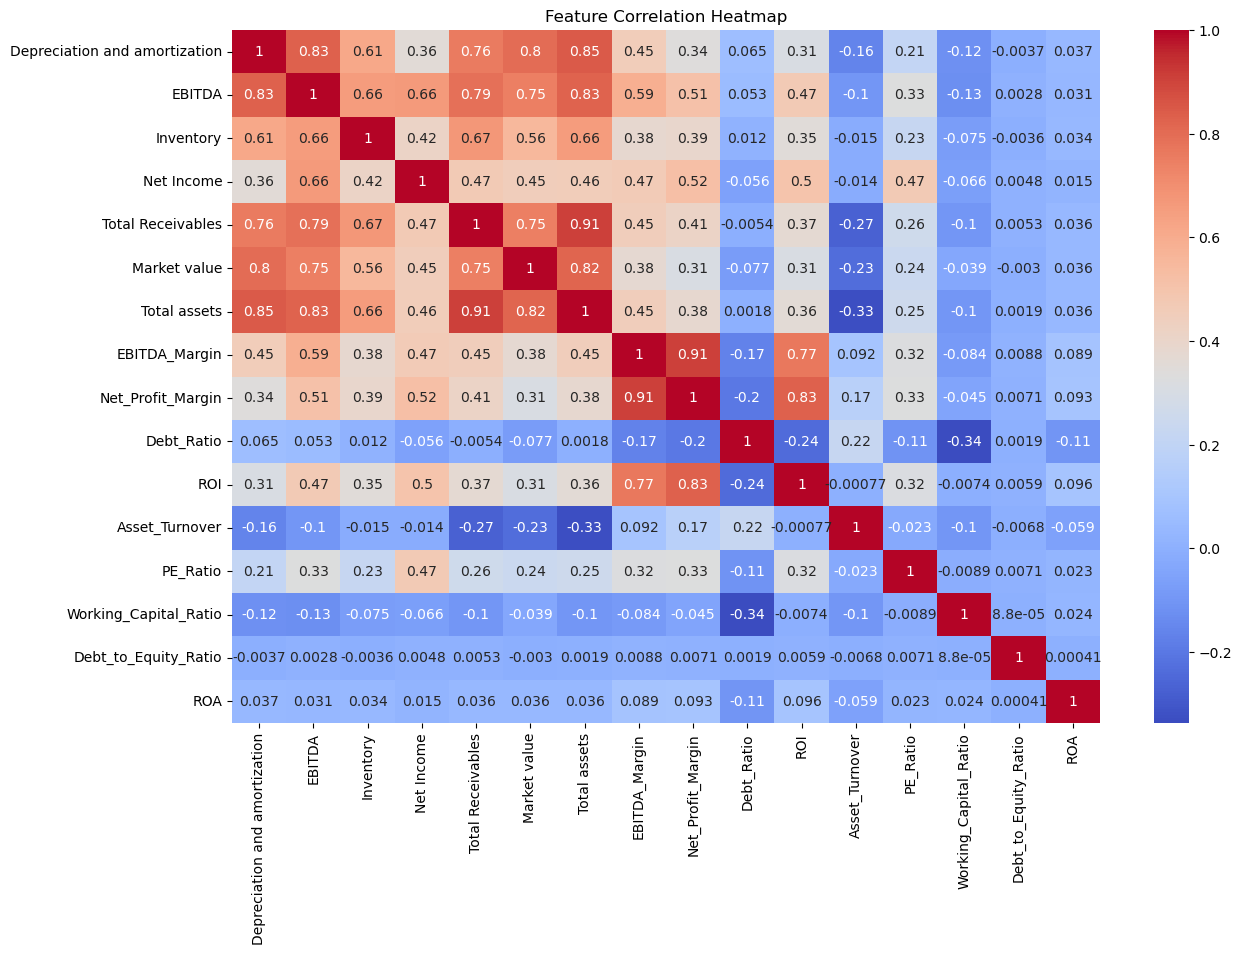

In [24]:
plt.figure(figsize=(14,9))
sns.heatmap(x.corr(), annot=True, cmap = 'coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## **Feature Selection**

**Mutual Info Gain**

In [25]:
x

,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market value,Total assets,EBITDA_Margin,Net_Profit_Margin,Debt_Ratio,ROI,Asset_Turnover,PE_Ratio,Working_Capital_Ratio,Debt_to_Equity_Ratio,ROA
0,50.438474,127.150053,93.330913,36.263000,1517.46125,748.541426,13994.35025,0.094783,0.027032,0.516345,0.096470,0.054114,20.642016,0.772000,11.527381,0.002591
1,74.442036,179.669458,93.330913,51.859783,1517.46125,1969.295220,13994.35025,0.335686,0.094462,0.692801,0.077607,0.013908,16.700041,-0.461716,11.527381,0.003706
2,11.712067,29.013467,1.691133,22.602200,143.74900,624.822920,2676.48500,0.457493,0.356398,0.103722,0.765114,0.023695,27.644341,2.111186,0.096406,0.008445
3,74.442036,179.669458,93.330913,51.859783,1517.46125,1969.295220,13994.35025,0.306428,0.161618,0.693773,0.397989,0.041710,21.313677,0.772000,11.527381,0.003706
4,74.442036,179.669458,93.330913,51.859783,1517.46125,1969.295220,13994.35025,0.019363,0.009048,0.779673,0.090789,0.178581,19.162632,0.772000,11.527381,0.003706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966,74.442036,179.669458,93.330913,51.859783,1517.46125,1969.295220,13994.35025,0.104797,0.024869,0.934194,0.285616,0.222137,20.651639,0.632237,11.527381,0.003706
8967,3.350333,6.168333,50.680667,-0.297667,79.57300,15.173600,356.25500,0.049575,-0.002392,0.758308,-0.047520,0.349256,-50.975140,0.811628,5.355117,-0.000836
8968,74.442036,179.669458,93.330913,51.859783,1517.46125,1969.295220,13994.35025,0.166990,0.097016,0.651418,0.258583,0.044016,21.309037,0.210809,11.527381,0.003706
8969,74.442036,179.669458,93.330913,-53.000618,1517.46125,1969.295220,13994.35025,0.079947,-0.021622,0.693392,-0.064262,0.050328,-37.093364,0.772000,-9.735783,-0.003787


<Axes: >

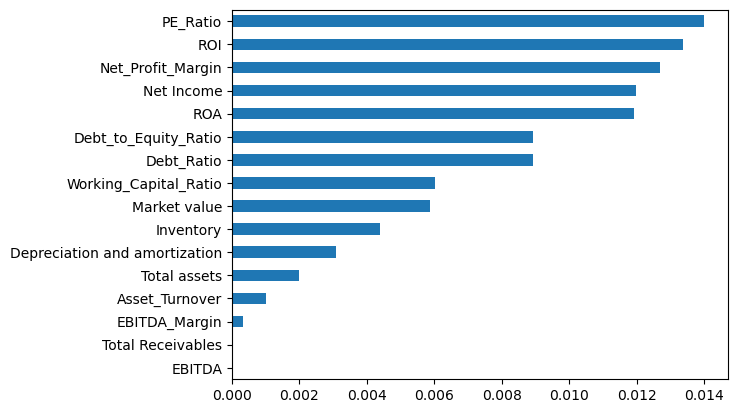

In [26]:
arr = mutual_info_classif(x,y)
s1 = pd.Series(arr, index = x.columns)
s1.sort_values().plot(kind = 'barh')

**ANOVA TEST**

In [27]:
f_val, p_val = f_classif(x,y)
df1_anova = pd.DataFrame({'F-val' : f_val, 'P-val' : np.around(p_val, 3)}, index = x.columns)
df1_anova.sort_values('P-val')

,F-val,P-val
Net Income,168.884417,0.000
Market value,33.617502,0.000
Debt_Ratio,66.316228,0.000
Working_Capital_Ratio,15.566617,0.000
PE_Ratio,44.040431,0.000
Asset_Turnover,13.154914,0.000
Net_Profit_Margin,19.073296,0.000
EBITDA_Margin,5.809169,0.016
Depreciation and amortization,4.662657,0.031
EBITDA,2.554232,0.110


In [28]:
# ffs_model = RandomForestClassifier()
# for i in range (10, x.shape[1]):
#     sfs = SequentialFeatureSelector(ffs_model, n_features_to_select= i, direction='forward', n_jobs=1)
#     sfs.fit(x,y)
#     selected_features = x.columns[sfs.get_support()]
#     ffs_model.fit(x[selected_features], y)
#     accuracy = ffs_model.score(x[selected_features], y)
#     print(i, '>>', np.around(accuracy,4))

In [29]:
#x[selected_features]

In [30]:
x.columns

Index(['Depreciation and amortization', 'EBITDA', 'Inventory', 'Net Income',
       'Total Receivables', 'Market value', 'Total assets', 'EBITDA_Margin',
       'Net_Profit_Margin', 'Debt_Ratio', 'ROI', 'Asset_Turnover', 'PE_Ratio',
       'Working_Capital_Ratio', 'Debt_to_Equity_Ratio', 'ROA'],
      dtype='object')

## **IMBALANCE DATA HANDLING**

In [31]:
smote = SMOTE(random_state=69, sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(x, y)

print(X_resampled.shape)
print(X_resampled.head(8972))

D:\Adi\Anaconda\envs\adik1\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


(16724, 16)
      Depreciation and amortization      EBITDA  Inventory  Net Income  \
0                         50.438474  127.150053  93.330913   36.263000   
1                         74.442036  179.669458  93.330913   51.859783   
2                         11.712067   29.013467   1.691133   22.602200   
3                         74.442036  179.669458  93.330913   51.859783   
4                         74.442036  179.669458  93.330913   51.859783   
...                             ...         ...        ...         ...   
8967                       3.350333    6.168333  50.680667   -0.297667   
8968                      74.442036  179.669458  93.330913   51.859783   
8969                      74.442036  179.669458  93.330913  -53.000618   
8970                      74.442036  179.669458  93.330913   51.859783   
8971                       2.178577  -50.381601   9.620916  -40.516744   

      Total Receivables  Market value  Total assets  EBITDA_Margin  \
0           1517.461250    74

## **Train_Test_Split**

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=69)

## **MODEL WITHOUT SCALED DATA**

In [33]:
def evaluation(string, model, ind_var, act):
    print(string.center(50, '*'))
    pred = model.predict(ind_var)

    cnf_matrix = confusion_matrix(act, pred)
    print('Confusion Matrix : \n', cnf_matrix)

    mat_coef = matthews_corrcoef(act, pred)
    print('Matthews Correlation Coefficient:', mat_coef)

    clf_report = classification_report(act,pred)
    print('Classification Report :\n', clf_report)

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
dt_clf = DecisionTreeClassifier( max_depth=13, min_samples_split=9, min_samples_leaf=4,random_state=69)
dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=4, min_samples_split=9,
                       random_state=69)

In [36]:
evaluation('Train Data Evaluation', dt_clf, x_train, y_train)
print()
evaluation('Test Data Evaluation', dt_clf, x_test, y_test)

**************Train Data Evaluation***************
Confusion Matrix : 
 [[6453  287]
 [1089 5550]]
Matthews Correlation Coefficient: 0.7998869636002299
Classification Report :
               precision    recall  f1-score   support

           0       0.86      0.96      0.90      6740
           1       0.95      0.84      0.89      6639

    accuracy                           0.90     13379
   macro avg       0.90      0.90      0.90     13379
weighted avg       0.90      0.90      0.90     13379


***************Test Data Evaluation***************
Confusion Matrix : 
 [[1497  125]
 [ 354 1369]]
Matthews Correlation Coefficient: 0.7212715110974024
Classification Report :
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      1622
           1       0.92      0.79      0.85      1723

    accuracy                           0.86      3345
   macro avg       0.86      0.86      0.86      3345
weighted avg       0.86      0.86      0.86   

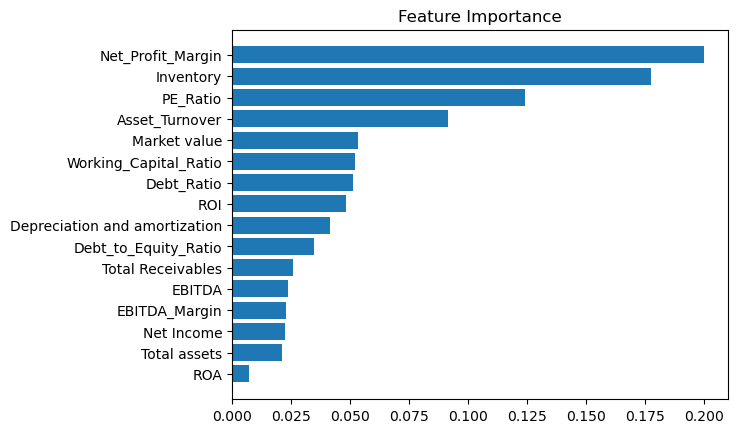

In [37]:
feature_importance = dt_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), x_train.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

## **RANDOM FOREST MODEL**

In [38]:
rf_model1 = RandomForestClassifier(n_estimators=80, max_depth=13, min_samples_split=9, min_samples_leaf=4,random_state=69, class_weight={0: 5, 1: 1}, oob_score=True)
rf_model1.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 5, 1: 1}, max_depth=13,
                       min_samples_leaf=4, min_samples_split=9, n_estimators=80,
                       oob_score=True, random_state=69)

In [39]:
evaluation('Train Data Evaluation', rf_model1, x_train, y_train)
print()
evaluation('Test Data Evaluation', rf_model1, x_test, y_test)

**************Train Data Evaluation***************
Confusion Matrix : 
 [[6726   14]
 [1605 5034]]
Matthews Correlation Coefficient: 0.7799957567323457
Classification Report :
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      6740
           1       1.00      0.76      0.86      6639

    accuracy                           0.88     13379
   macro avg       0.90      0.88      0.88     13379
weighted avg       0.90      0.88      0.88     13379


***************Test Data Evaluation***************
Confusion Matrix : 
 [[1580   42]
 [ 468 1255]]
Matthews Correlation Coefficient: 0.7205618271570425
Classification Report :
               precision    recall  f1-score   support

           0       0.77      0.97      0.86      1622
           1       0.97      0.73      0.83      1723

    accuracy                           0.85      3345
   macro avg       0.87      0.85      0.85      3345
weighted avg       0.87      0.85      0.85   

In [40]:
rf_model1.oob_score_

0.8490171163764108

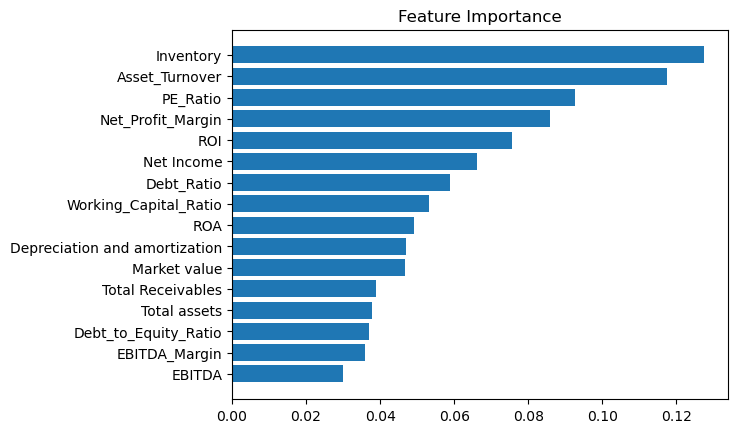

In [41]:
feature_importance = rf_model1.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), x_train.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [42]:
explainer = shap.TreeExplainer(rf_model1)

shap_values  = explainer.shap_values(x_train)
shap_values

array([[[ 0.00373657, -0.00373657],
        [-0.00491228,  0.00491228],
        [ 0.01934829, -0.01934829],
        ...,
        [-0.00125932,  0.00125932],
        [-0.00509926,  0.00509926],
        [ 0.00794904, -0.00794904]],

       [[ 0.00316579, -0.00316579],
        [ 0.00252932, -0.00252932],
        [ 0.0280608 , -0.0280608 ],
        ...,
        [ 0.00350561, -0.00350561],
        [-0.00278915,  0.00278915],
        [ 0.00274677, -0.00274677]],

       [[ 0.0135367 , -0.0135367 ],
        [-0.00121098,  0.00121098],
        [ 0.02939822, -0.02939822],
        ...,
        [ 0.00525655, -0.00525655],
        [-0.00857363,  0.00857363],
        [ 0.00524576, -0.00524576]],

       ...,

       [[ 0.01347739, -0.01347739],
        [-0.00327087,  0.00327087],
        [ 0.03443959, -0.03443959],
        ...,
        [-0.01043018,  0.01043018],
        [-0.00421501,  0.00421501],
        [ 0.00675689, -0.00675689]],

       [[ 0.00733689, -0.00733689],
        [ 0.00074701, -0.00

In [43]:
shap_values.shape

(13379, 16, 2)

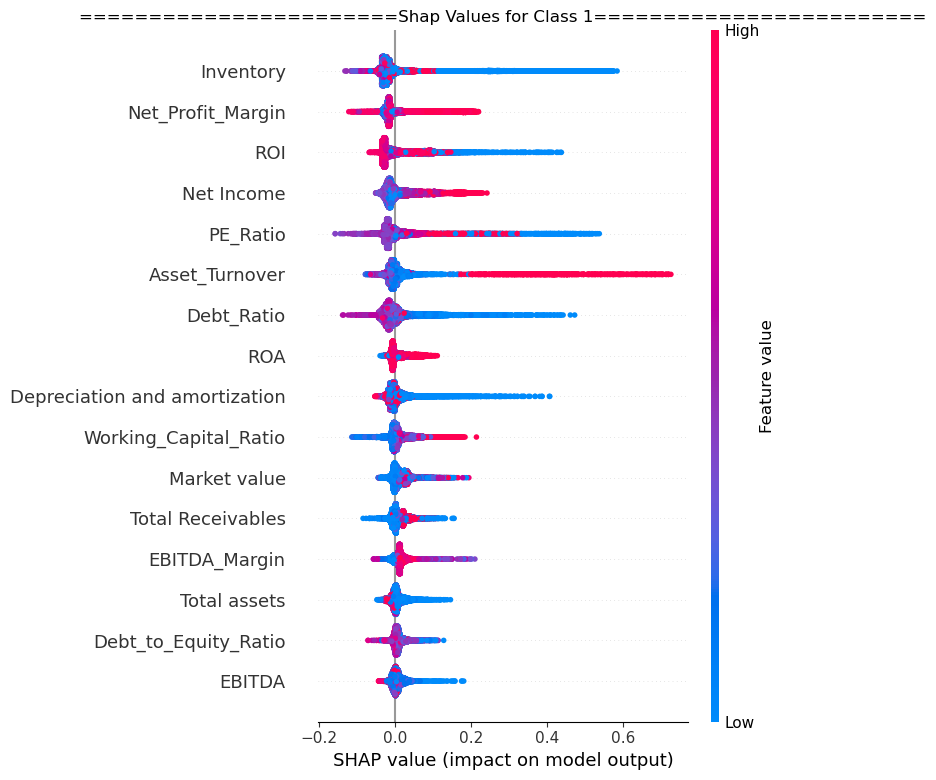

In [44]:
plt.title('Shap Values for Class 1'.center(70, '='))
shap.summary_plot(shap_values[:,:,1], x_train, plot_type='dot')
plt.show()

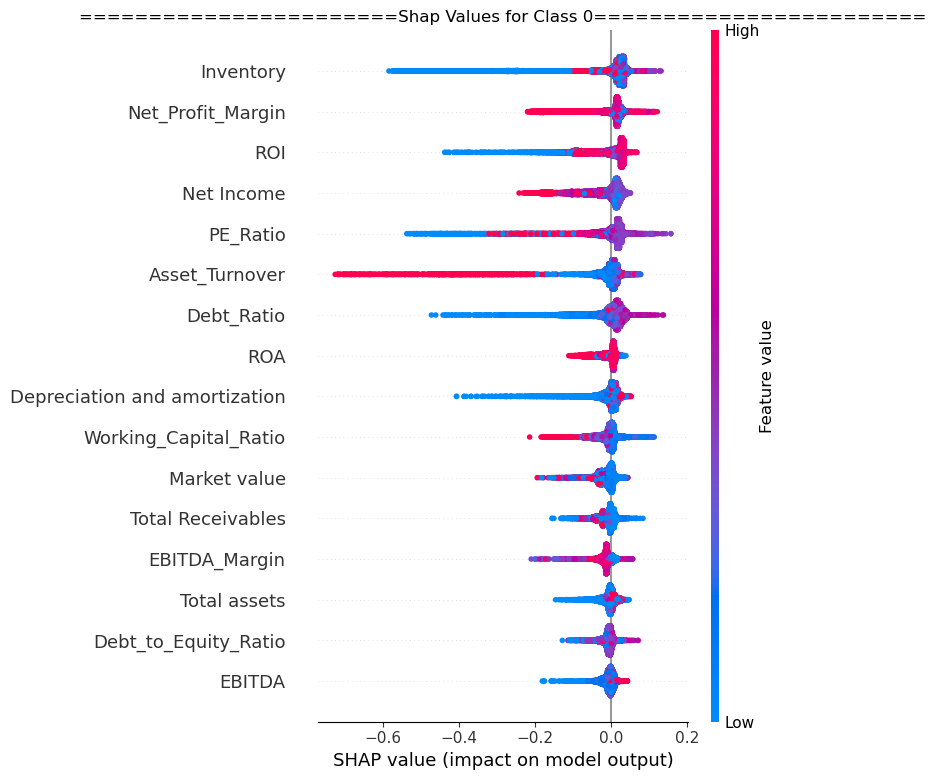

In [45]:
plt.title('Shap Values for Class 0'.center(70, '='))
shap.summary_plot(shap_values[:,:,0], x_train, plot_type='dot')
plt.show()

In [46]:
print("Model Expected Features:", rf_model1.feature_names_in_)


Model Expected Features: ['Depreciation and amortization' 'EBITDA' 'Inventory' 'Net Income'
 'Total Receivables' 'Market value' 'Total assets' 'EBITDA_Margin'
 'Net_Profit_Margin' 'Debt_Ratio' 'ROI' 'Asset_Turnover' 'PE_Ratio'
 'Working_Capital_Ratio' 'Debt_to_Equity_Ratio' 'ROA']


In [47]:
from sklearn.ensemble import AdaBoostClassifier

In [48]:
adb_model = AdaBoostClassifier(n_estimators=2000, learning_rate=1.5, random_state=69)
adb_model.fit(x_train, y_train)

AdaBoostClassifier(learning_rate=1.5, n_estimators=2000, random_state=69)

In [49]:
evaluation('Train Data Evaluation', adb_model, x_train, y_train)
print()
evaluation('Test Data Evaluation', adb_model, x_test, y_test)

**************Train Data Evaluation***************
Confusion Matrix : 
 [[5810  930]
 [1260 5379]]
Matthews Correlation Coefficient: 0.6733010968084502
Classification Report :
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      6740
           1       0.85      0.81      0.83      6639

    accuracy                           0.84     13379
   macro avg       0.84      0.84      0.84     13379
weighted avg       0.84      0.84      0.84     13379


***************Test Data Evaluation***************
Confusion Matrix : 
 [[1369  253]
 [ 359 1364]]
Matthews Correlation Coefficient: 0.6357224961943847
Classification Report :
               precision    recall  f1-score   support

           0       0.79      0.84      0.82      1622
           1       0.84      0.79      0.82      1723

    accuracy                           0.82      3345
   macro avg       0.82      0.82      0.82      3345
weighted avg       0.82      0.82      0.82   

## **HYPERPARAMETER TUNING**

In [77]:
rf_model2 = RandomForestClassifier(random_state=69, )

param_grid = {'n_estimators':np.arange(70,120,10) , 'max_depth':np.arange(8,15),
             'min_samples_split' : np.arange(4,10),'min_samples_leaf':np.arange(3,9)}

rscv_rf_clf = RandomizedSearchCV(rf_model, param_grid, cv=3, scoring='precision',n_iter=150)
rscv_rf_clf.fit(x_train, y_train)
rscv_rf_clf.best_estimator_

RandomForestClassifier(class_weight={0: 5, 1: 1}, max_depth=np.int64(8),
                       min_samples_leaf=np.int64(7),
                       min_samples_split=np.int64(4),
                       n_estimators=np.int64(110), oob_score=True,
                       random_state=69)

In [84]:
rf_model3 = RandomForestClassifier(n_estimators=110, max_depth=8, min_samples_split=4, min_samples_leaf=7,random_state=69, oob_score=True)
rf_model3.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=7, min_samples_split=4,
                       n_estimators=110, oob_score=True, random_state=69)

In [85]:
evaluation('Train Data Evaluation', rf_model3, x_train, y_train)
print()
evaluation('Test Data Evaluation', rf_model3, x_test, y_test)

**************Train Data Evaluation***************
Confusion Matrix : 
 [[6088  652]
 [1330 5309]]
Matthews Correlation Coefficient: 0.7071182828834471
Classification Report :
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      6740
           1       0.89      0.80      0.84      6639

    accuracy                           0.85     13379
   macro avg       0.86      0.85      0.85     13379
weighted avg       0.86      0.85      0.85     13379


***************Test Data Evaluation***************
Confusion Matrix : 
 [[1426  196]
 [ 358 1365]]
Matthews Correlation Coefficient: 0.6725745512192207
Classification Report :
               precision    recall  f1-score   support

           0       0.80      0.88      0.84      1622
           1       0.87      0.79      0.83      1723

    accuracy                           0.83      3345
   macro avg       0.84      0.84      0.83      3345
weighted avg       0.84      0.83      0.83   

In [86]:
rf_model2 = RandomForestClassifier(n_estimators=70, max_depth=14, min_samples_split=4, min_samples_leaf=3,random_state=69, oob_score=True)
rf_model2.fit(x_train, y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=70, oob_score=True, random_state=69)

In [87]:
evaluation('Train Data Evaluation', rf_model2, x_train, y_train)
print()
evaluation('Test Data Evaluation', rf_model2, x_test, y_test)

**************Train Data Evaluation***************
Confusion Matrix : 
 [[6639  101]
 [ 720 5919]]
Matthews Correlation Coefficient: 0.8809629560027847
Classification Report :
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      6740
           1       0.98      0.89      0.94      6639

    accuracy                           0.94     13379
   macro avg       0.94      0.94      0.94     13379
weighted avg       0.94      0.94      0.94     13379


***************Test Data Evaluation***************
Confusion Matrix : 
 [[1520  102]
 [ 271 1452]]
Matthews Correlation Coefficient: 0.7814391835869161
Classification Report :
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      1622
           1       0.93      0.84      0.89      1723

    accuracy                           0.89      3345
   macro avg       0.89      0.89      0.89      3345
weighted avg       0.89      0.89      0.89   

In [52]:
rf_model2.oob_score_

0.8922938934150535

In [53]:
rf_model2.feature_importances_

array([0.04028084, 0.03032238, 0.13310971, 0.08846645, 0.04008123,
       0.04380761, 0.04070298, 0.02755733, 0.08663476, 0.06694583,
       0.08581153, 0.08433466, 0.09292877, 0.03955224, 0.03987524,
       0.05958841])

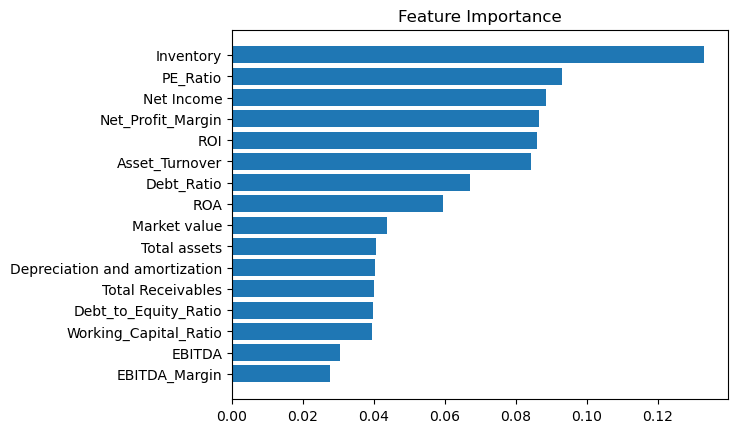

In [54]:
feature_importance = rf_model2.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), x_train.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [55]:
explainer = shap.TreeExplainer(rf_model2)

shap_values2  = explainer.shap_values(x_train)
shap_values2

array([[[ 0.00391972, -0.00391972],
        [-0.00696776,  0.00696776],
        [ 0.04657619, -0.04657619],
        ...,
        [ 0.0027661 , -0.0027661 ],
        [-0.00384397,  0.00384397],
        [ 0.0132863 , -0.0132863 ]],

       [[ 0.02197142, -0.02197142],
        [ 0.0044609 , -0.0044609 ],
        [ 0.06330791, -0.06330791],
        ...,
        [ 0.00830476, -0.00830476],
        [-0.00401619,  0.00401619],
        [ 0.01099498, -0.01099498]],

       [[ 0.0294808 , -0.0294808 ],
        [ 0.00818667, -0.00818667],
        [ 0.06984697, -0.06984697],
        ...,
        [ 0.01620554, -0.01620554],
        [-0.00125511,  0.00125511],
        [ 0.01622149, -0.01622149]],

       ...,

       [[ 0.00074763, -0.00074763],
        [-0.002613  ,  0.002613  ],
        [ 0.0636374 , -0.0636374 ],
        ...,
        [ 0.01376738, -0.01376738],
        [-0.00277998,  0.00277998],
        [ 0.00381181, -0.00381181]],

       [[ 0.00756178, -0.00756178],
        [-0.00704814,  0.00

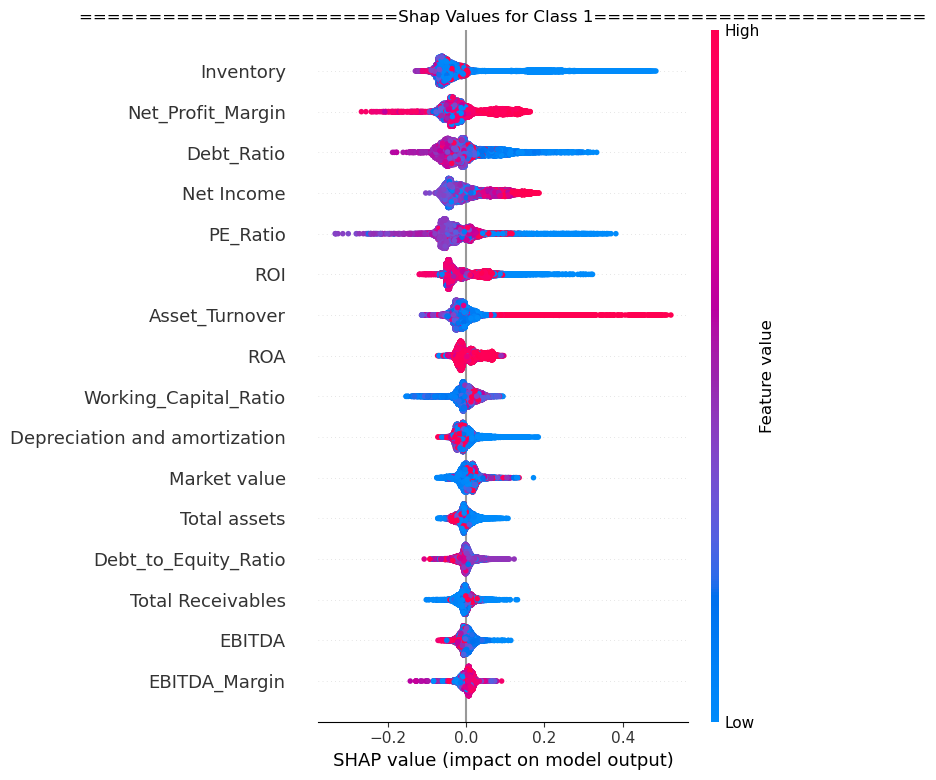

In [56]:
plt.title('Shap Values for Class 1'.center(70, '='))
shap.summary_plot(shap_values2[:,:,1], x_train, plot_type='dot')
plt.show()

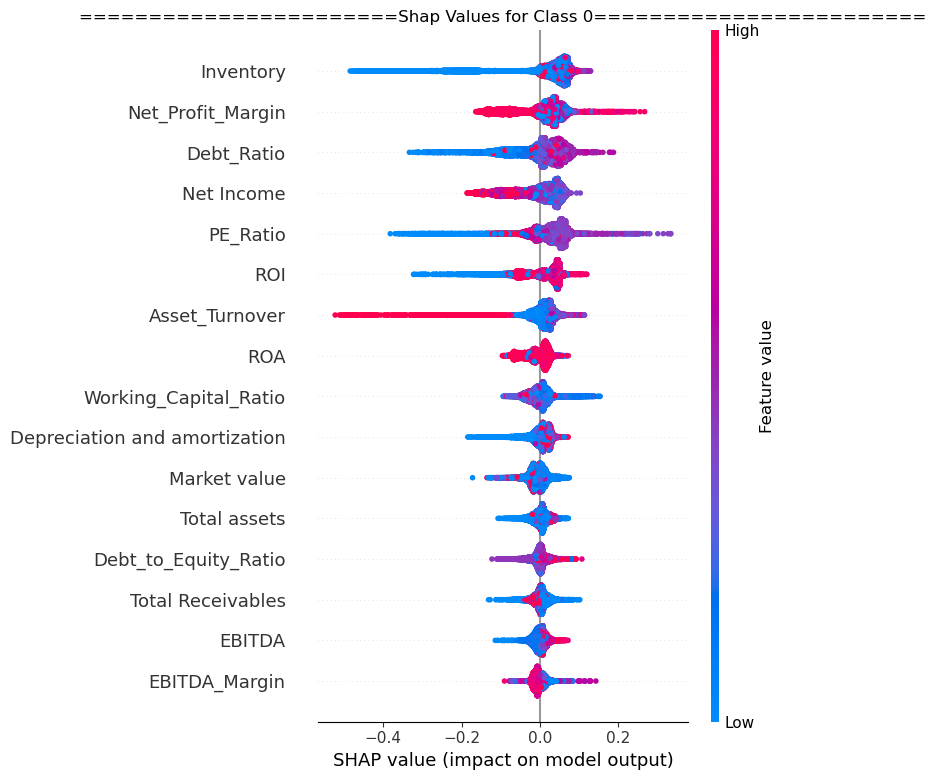

In [57]:
plt.title('Shap Values for Class 0'.center(70, '='))
shap.summary_plot(shap_values2[:,:,0], x_train, plot_type='dot')
plt.show()

## **DATA TIE BACK**

In [58]:
predictions = rf_model1.predict(X_resampled)

In [59]:
original_indices = df1.index

In [60]:
predictions_for_original_data = predictions[:len(original_indices)]


In [61]:
results = pd.DataFrame({
    "Original_Index": original_indices,  # Use the original indices from before SMOTE
    "Prediction": predictions_for_original_data,  # Only predictions for original data
    "company_name": df1['company_name']  # Include the 'company_name' column
})


In [62]:
df_results = df1.set_index('Original_Index').join(results.set_index('Original_Index'), lsuffix='_df', rsuffix='_results')


In [63]:
print(df_results[['company_name_df', 'status_label', 'Prediction']])


               company_name_df  status_label  Prediction
Original_Index                                          
0                          C_1             1           1
1                         C_10             1           1
2                        C_100             1           1
3                       C_1000             1           1
4                       C_1001             1           1
...                        ...           ...         ...
8966                     C_995             1           1
8967                     C_996             1           0
8968                     C_997             1           1
8969                     C_998             0           0
8970                     C_999             1           1

[8971 rows x 3 columns]


In [64]:
df_results = df_results.reset_index()

In [65]:
final_result = df1.merge(df_results, how='left', on='Original_Index')


In [66]:
final_result.to_csv('clinet_predictions_final.csv', index=False)


## **--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## **MODEL USING SCALED DATA**

In [67]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [68]:
x_train_scaled.shape

(13379, 16)

In [69]:
rf_model = RandomForestClassifier(n_estimators=95, max_depth=12, min_samples_split=7, min_samples_leaf=4,random_state=69,class_weight={0: 5, 1: 1}, oob_score=True)
rf_model.fit(x_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 5, 1: 1}, max_depth=12,
                       min_samples_leaf=4, min_samples_split=7, n_estimators=95,
                       oob_score=True, random_state=69)

In [70]:
evaluation('Train Data Evaluation', rf_model, x_train_scaled, y_train)
print()
evaluation('Test Data Evaluation', rf_model, x_test_scaled, y_test)

**************Train Data Evaluation***************
Confusion Matrix : 
 [[6724   16]
 [1737 4902]]
Matthews Correlation Coefficient: 0.7632174260042108
Classification Report :
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      6740
           1       1.00      0.74      0.85      6639

    accuracy                           0.87     13379
   macro avg       0.90      0.87      0.87     13379
weighted avg       0.89      0.87      0.87     13379


***************Test Data Evaluation***************
Confusion Matrix : 
 [[1580   42]
 [ 488 1235]]
Matthews Correlation Coefficient: 0.7107214294657951
Classification Report :
               precision    recall  f1-score   support

           0       0.76      0.97      0.86      1622
           1       0.97      0.72      0.82      1723

    accuracy                           0.84      3345
   macro avg       0.87      0.85      0.84      3345
weighted avg       0.87      0.84      0.84   

In [71]:
rf_model.oob_score_

0.8384782121234771

In [72]:
rf_model.feature_importances_

array([0.04627882, 0.02832934, 0.13424586, 0.06680212, 0.03509774,
       0.04608045, 0.03557818, 0.03758383, 0.09239239, 0.06067456,
       0.07488735, 0.1181066 , 0.09142889, 0.0504167 , 0.03666693,
       0.04543022])

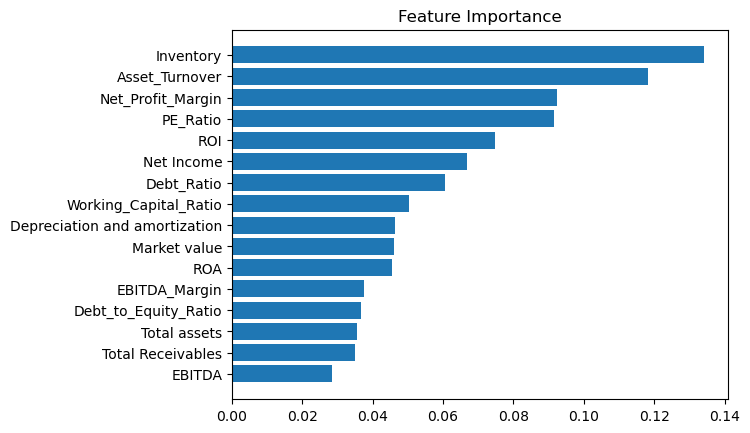

In [73]:
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), x_train.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [74]:
explainer = shap.TreeExplainer(rf_model)

shap_values1  = explainer.shap_values(x_train_scaled)
shap_values1

array([[[ 1.03583020e-03, -1.03583020e-03],
        [-4.07151223e-03,  4.07151223e-03],
        [ 2.08513297e-02, -2.08513297e-02],
        ...,
        [-1.15719023e-03,  1.15719023e-03],
        [-4.32821345e-03,  4.32821345e-03],
        [ 4.66541994e-03, -4.66541994e-03]],

       [[ 3.24316117e-03, -3.24316117e-03],
        [-1.25082820e-04,  1.25082820e-04],
        [ 2.71126886e-02, -2.71126886e-02],
        ...,
        [ 4.07201340e-03, -4.07201340e-03],
        [-1.71375963e-03,  1.71375963e-03],
        [ 3.12000939e-05, -3.12000939e-05]],

       [[ 3.50012480e-03, -3.50012480e-03],
        [-3.44609417e-03,  3.44609417e-03],
        [ 2.94179559e-02, -2.94179559e-02],
        ...,
        [ 6.32673449e-03, -6.32673449e-03],
        [-7.21198802e-03,  7.21198802e-03],
        [ 5.04666320e-03, -5.04666320e-03]],

       ...,

       [[ 5.06855227e-03, -5.06855227e-03],
        [-8.23923059e-03,  8.23923059e-03],
        [ 3.32257967e-02, -3.32257967e-02],
        ...,
     

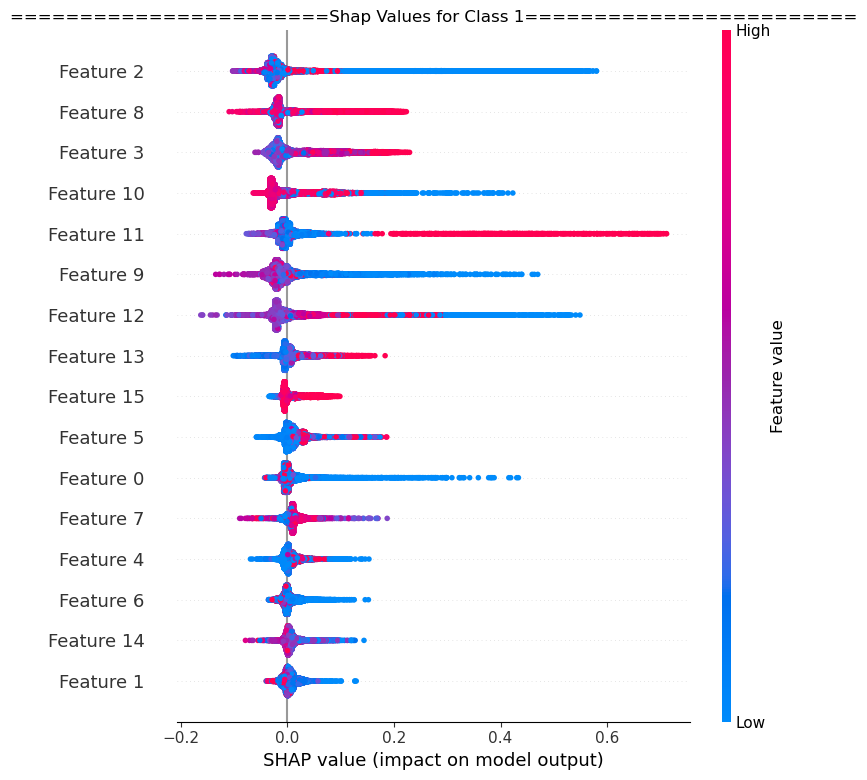

In [75]:
plt.title('Shap Values for Class 1'.center(70, '='))
shap.summary_plot(shap_values1[:,:,1], x_train_scaled, plot_type='dot')
plt.show()

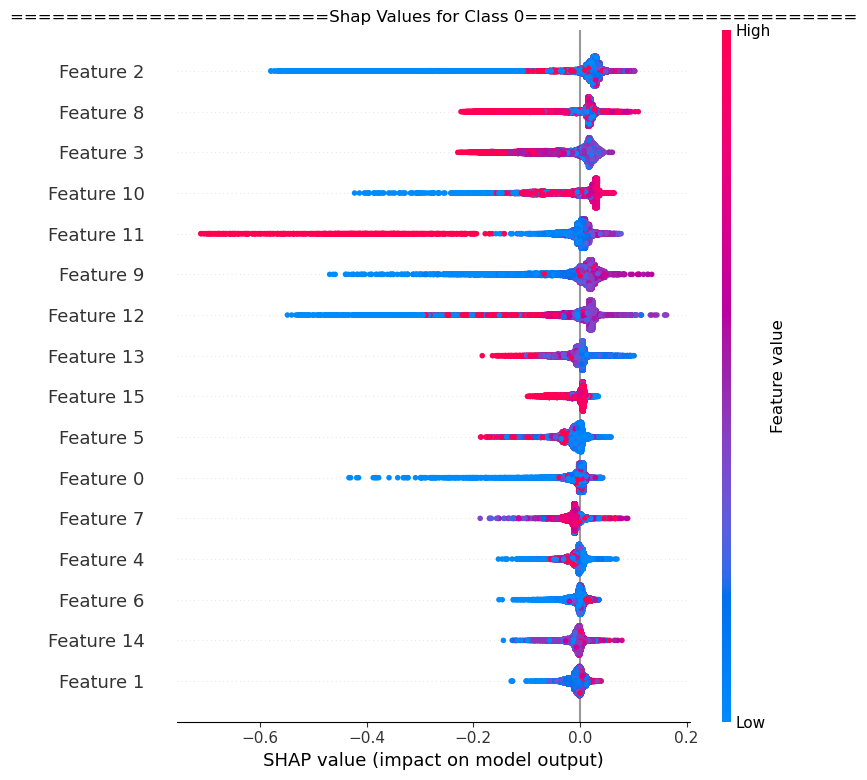

In [76]:
plt.title('Shap Values for Class 0'.center(70, '='))
shap.summary_plot(shap_values1[:,:,0], x_train_scaled, plot_type='dot')
plt.show()

## **HYPERPARAMETER TUNING**

In [78]:
rf_model = RandomForestClassifier(random_state=69, )

param_grid = {'n_estimators':np.arange(70,120,10) , 'max_depth':np.arange(8,15),
             'min_samples_split' : np.arange(4,10),'min_samples_leaf':np.arange(3,9)}

rscv_rf_clf = RandomizedSearchCV(rf_model, param_grid, cv=3, scoring='precision',n_iter=150)
rscv_rf_clf.fit(x_train_scaled, y_train)
rscv_rf_clf.best_estimator_

RandomForestClassifier(max_depth=np.int64(13), min_samples_leaf=np.int64(3),
                       min_samples_split=np.int64(5), n_estimators=np.int64(80),
                       random_state=69)

In [93]:
rscv_rf_clf.best_params_

{'n_estimators': np.int64(80),
 'min_samples_split': np.int64(4),
 'min_samples_leaf': np.int64(3),
 'max_depth': np.int64(14)}

In [98]:
rf_model_sc = RandomForestClassifier(n_estimators=80, max_depth=14, min_samples_split=4, min_samples_leaf=3,random_state=69, oob_score=True)
rf_model_sc.fit(x_train_scaled, y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=3, min_samples_split=4,
                       n_estimators=80, oob_score=True, random_state=69)

In [99]:
evaluation('Train Data Evaluation', rf_model_sc, x_train_scaled, y_train)
print()
evaluation('Test Data Evaluation', rf_model_sc, x_test_scaled, y_test)

**************Train Data Evaluation***************
Confusion Matrix : 
 [[6643   97]
 [ 729 5910]]
Matthews Correlation Coefficient: 0.8803716339851416
Classification Report :
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      6740
           1       0.98      0.89      0.93      6639

    accuracy                           0.94     13379
   macro avg       0.94      0.94      0.94     13379
weighted avg       0.94      0.94      0.94     13379


***************Test Data Evaluation***************
Confusion Matrix : 
 [[1524   98]
 [ 270 1453]]
Matthews Correlation Coefficient: 0.7845934321755382
Classification Report :
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      1622
           1       0.94      0.84      0.89      1723

    accuracy                           0.89      3345
   macro avg       0.89      0.89      0.89      3345
weighted avg       0.89      0.89      0.89   

In [100]:
rf_model_sc.oob_score_

0.8926676134240227

IndexError: index 16 is out of bounds for axis 0 with size 16

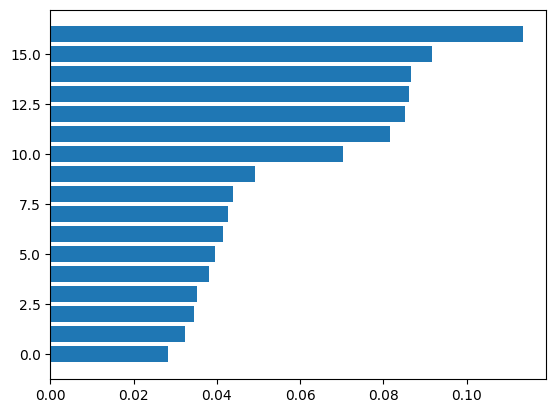

In [171]:
feature_importance = rf_model_sc.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), x_train.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [172]:
explainer = shap.TreeExplainer(rf_model_sc)

shap_values2  = explainer.shap_values(x_train_scaled)
shap_values2

array([[[ 0.02505466, -0.02505466],
        [ 0.0154377 , -0.0154377 ],
        [ 0.00013218, -0.00013218],
        ...,
        [ 0.00801298, -0.00801298],
        [ 0.00734078, -0.00734078],
        [ 0.01924739, -0.01924739]],

       [[-0.00501377,  0.00501377],
        [ 0.01697225, -0.01697225],
        [ 0.00113628, -0.00113628],
        ...,
        [ 0.00810522, -0.00810522],
        [ 0.00318253, -0.00318253],
        [ 0.02095004, -0.02095004]],

       [[ 0.05061757, -0.05061757],
        [ 0.0185048 , -0.0185048 ],
        [ 0.01097172, -0.01097172],
        ...,
        [ 0.00818689, -0.00818689],
        [ 0.02533775, -0.02533775],
        [ 0.0182101 , -0.0182101 ]],

       ...,

       [[ 0.01291577, -0.01291577],
        [ 0.00070763, -0.00070763],
        [-0.00125214,  0.00125214],
        ...,
        [ 0.05253432, -0.05253432],
        [ 0.03180681, -0.03180681],
        [ 0.00627893, -0.00627893]],

       [[ 0.01556579, -0.01556579],
        [ 0.00724871, -0.00

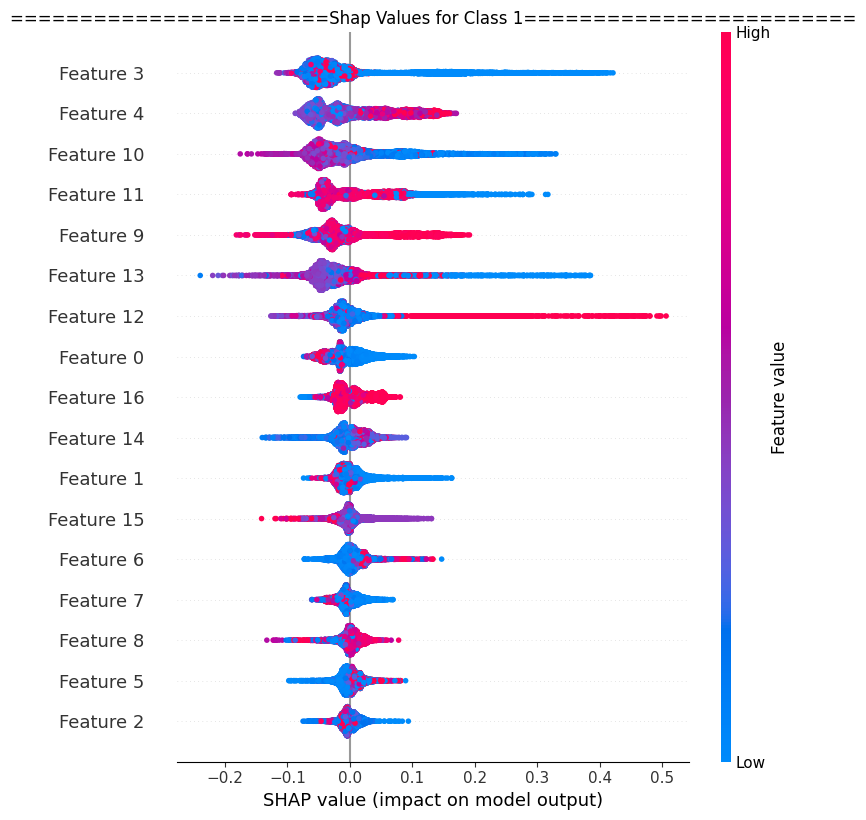

In [173]:
plt.title('Shap Values for Class 1'.center(70, '='))
shap.summary_plot(shap_values2[:,:,1], x_train_scaled, plot_type='dot')
plt.show()

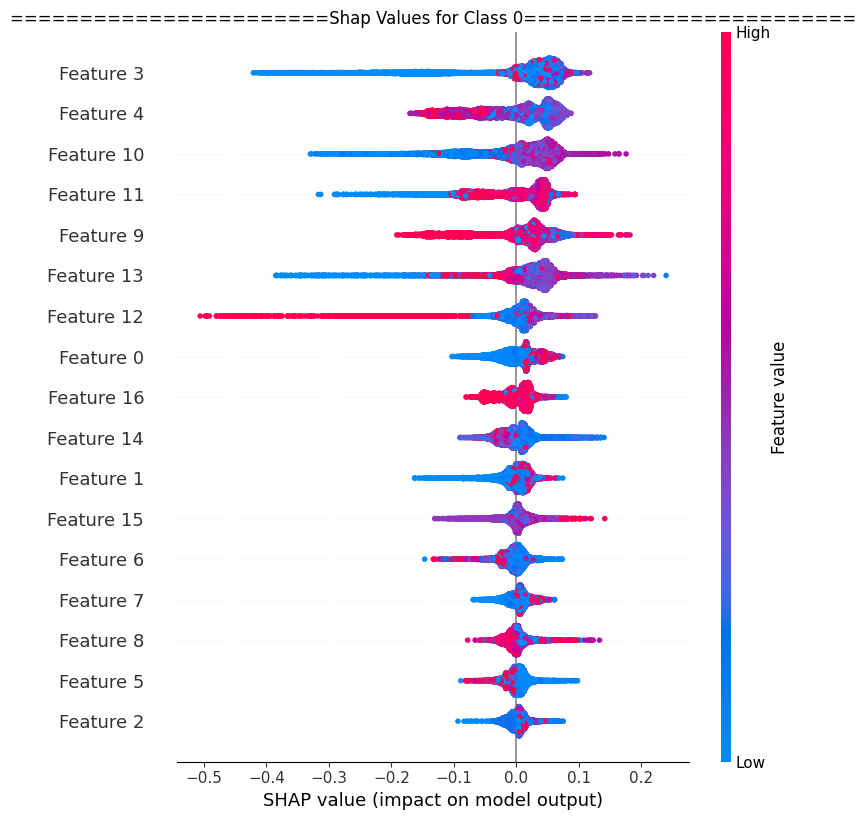

In [174]:
plt.title('Shap Values for Class 0'.center(70, '='))
shap.summary_plot(shap_values2[:,:,0], x_train_scaled, plot_type='dot')
plt.show()

In [152]:
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)

# Display the first few rows of the DataFrame
print(x_train_scaled_df.head())

   Cost of goods sold  Depreciation and amortization    EBITDA  Inventory  \
0           -0.554108                      -0.658390 -0.461737  -0.438305   
1           -0.688370                      -0.736509 -0.683384  -0.657622   
2            1.023938                       1.022467  0.599361   1.648066   
3            1.901710                       1.955731  1.991572   1.369978   
4           -0.560476                      -0.714130 -0.498605  -0.163695   

   Net Income  Total Receivables  Market value  Total assets  Original_Index  \
0    0.056704          -0.536634     -0.712664     -0.639670       -0.820174   
1   -0.271038          -0.692030     -0.558633     -0.637943       -0.820174   
2   -1.653173          -0.101369     -0.540806     -0.043772       -0.820174   
3    2.096478           2.030017      2.098671      1.975558        1.208743   
4   -0.113858          -0.494420     -0.711676     -0.670942       -0.820174   

   EBITDA_Margin  Net_Profit_Margin  Debt_Ratio       RO

In [153]:
x_train_scaled_df.columns

Index(['Cost of goods sold', 'Depreciation and amortization', 'EBITDA',
       'Inventory', 'Net Income', 'Total Receivables', 'Market value',
       'Total assets', 'Original_Index', 'EBITDA_Margin', 'Net_Profit_Margin',
       'Debt_Ratio', 'ROI', 'Asset_Turnover', 'PE_Ratio',
       'Working_Capital_Ratio', 'Debt_to_Equity_Ratio', 'ROA'],
      dtype='object')

In [154]:
y_resampled.value_counts

<bound method IndexOpsMixin.value_counts of 0        1
1        1
2        1
3        1
4        1
        ..
16719    0
16720    0
16721    0
16722    0
16723    0
Name: status_label, Length: 16724, dtype: int64>

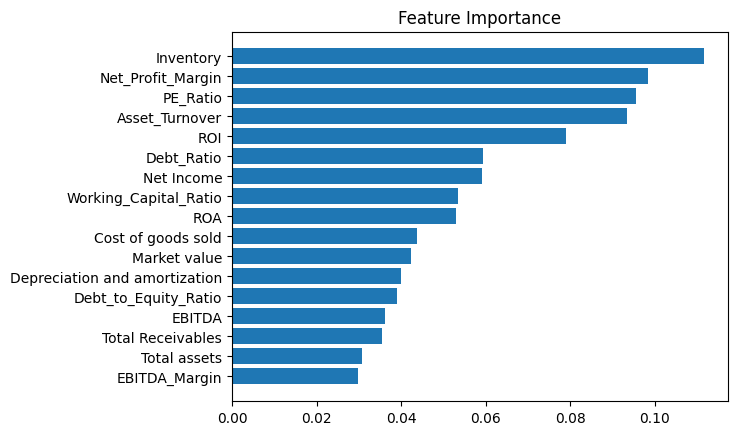

In [191]:
feature_importance = rf_model1.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), x_train.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

## **API AND MODEL DEPLOYMENT**

## without scaled model

In [46]:
rf_model1

RandomForestClassifier(class_weight={0: 5, 1: 1}, max_depth=13,
                       min_samples_leaf=4, min_samples_split=9, n_estimators=80,
                       oob_score=True, random_state=69)

In [47]:
import joblib

# Assuming `model` is your trained model
joblib.dump(rf_model1, 'rf_model1.pkl')


['rf_model1.pkl']

## scaled model

In [101]:
import pickle

In [102]:
with open('rf_model_sc.pkl', 'wb') as model_file:
    pickle.dump(rf_model_sc, model_file)

In [104]:
with open('std_scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [130]:
print("Training columns:", x_train.columns.tolist())

Training columns: ['Depreciation and amortization', 'EBITDA', 'Inventory', 'Net Income', 'Total Receivables', 'Market value', 'Total assets', 'EBITDA_Margin', 'Net_Profit_Margin', 'Debt_Ratio', 'ROI', 'Asset_Turnover', 'PE_Ratio', 'Working_Capital_Ratio', 'Debt_to_Equity_Ratio', 'ROA']


In [137]:
rf_model_sc.predict_proba(x_train_scaled)[0]

array([0.83420388, 0.16579612])

In [143]:
print("Model classes:", rf_model_sc.classes_)  # Should output [0 1]

Model classes: [0 1]


In [145]:
x_train

,Depreciation and amortization,EBITDA,Inventory,Net Income,Total Receivables,Market value,Total assets,EBITDA_Margin,Net_Profit_Margin,Debt_Ratio,ROI,Asset_Turnover,PE_Ratio,Working_Capital_Ratio,Debt_to_Equity_Ratio,ROA
11689,4.122745,-3.391396,0.298988,-11.017547,53.651004,45.444107,862.353935,-0.025492,-0.083304,1.154637,-0.592271,0.153145,-4.154721,-0.479395,-1.172740,-0.012771
15170,4.713953,-9.457680,1.975641,-18.756932,19.465566,88.519228,586.041318,-0.306293,-0.490142,0.359844,-2.401096,0.126667,-5.144236,0.279658,-0.069311,-0.031707
15681,20.551892,31.357379,20.473300,-24.711168,232.602512,237.013082,4380.914675,0.049210,-0.125027,0.771828,-0.315803,0.060588,-10.695108,0.328528,-12.892999,-0.005593
5955,74.442036,179.669458,72.210526,51.859783,1517.461250,1811.228984,13994.350250,0.152154,0.036901,0.579373,0.099742,0.042690,17.738841,0.772000,11.527381,0.003706
15819,1.992837,3.396387,19.766377,-9.054155,130.465132,5.736479,368.046147,0.024645,-0.066869,0.676254,-1.465215,0.373853,-1.240073,2.655527,-7.467886,-0.024499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4374,13.031250,4.774250,0.000000,-9.802500,196.884000,1109.663925,1095.461000,0.025871,-0.053118,0.402594,-0.637981,0.168461,-53.771085,1.527916,-3.120370,-0.008948
11825,0.282964,-2.770029,1.601794,-4.000114,6.899917,8.614951,56.889060,-0.488175,-0.804547,1.184181,-2.900254,0.094212,-1.878215,-0.200322,-0.618634,-0.070221
14740,0.761921,-0.460695,3.754544,-2.075280,41.709001,31.841269,193.915621,-0.032928,-0.129567,0.266300,-0.855016,0.084497,-16.949129,3.586836,-0.726380,-0.010752
9818,0.654201,-0.654103,1.418423,-3.999282,31.118813,8.816463,98.859573,-0.013955,-0.161084,0.666844,-2.475638,0.372979,-4.748496,0.015554,1.984845,-0.041211


In [142]:
rf_model1.predict_proba(x_train)[0]

array([0.95755349, 0.04244651])